# Word2vec model based on Fetahu
This model uses a pretrained word2vec to vectorize the paragraphs, the sequential information of the sentences is maintained.

A pretrained word2vec can be found on [this github repo](https://github.com/3Top/word2vec-api).

The paper this is based on can be found [here](https://arxiv.org/pdf/1811.05740.pdf).

In [252]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import confusion_matrix
from gensim.utils import simple_preprocess
import itertools

In [259]:
df = pd.read_csv("../../data/ad_hominem/ad_hominems_cleaned_Murilo.csv", sep=",", index_col=0, header=0, names=["body", "isAdHominem"])
df = df[~df.isin([np.nan, np.inf, -np.inf, 'nan']).any(1)] ## Remove rows with NaN values
print(df.shape)

(29218, 2)


In [260]:
df["length"] = df["body"].apply( lambda x: len(simple_preprocess(x, deacc=True)))

In [261]:
df.drop(df[df["length"] > 200].index, axis=0, inplace=True)

In [262]:
df.shape

(26724, 3)

In [263]:
print("Setting paragraph length at {} words.".format(df["length"].max()))

Setting paragraph length at 200 words.


In [264]:
from sklearn.model_selection import train_test_split

train, test = train_test_split( df, test_size=0.3, random_state=1)

print("In total, the train contains", sum(train["isAdHominem"] == True), "ad hominems")
print("In total, the test contains", sum(test["isAdHominem"] == True), "ad hominems")

In total, the train contains 1586 ad hominems
In total, the test contains 693 ad hominems


In [265]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [214]:
print("importing word2vec")
wv_from_bin = KeyedVectors.load_word2vec_format("~/notebooks/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin.gz", binary=True)  # C binary format
print("imported word2vec")

importing word2vec
imported word2vec


In [266]:
def combineData( dataset, length ):  
    paragraphRepresentations = np.zeros((len(dataset), maxLength, 300))
    
    for i, paragraph in enumerate(dataset["body"]):
        if (100* i / dataset.shape[0] % 10 == 0):
            print("{} of {} ({} %)\r".format(i, dataset.shape[0], 100* i / dataset.shape[0]))
        
        # Enumerate over the words in the tags-array (col 0 = words, col 1 = POS tags)
        for j, word in enumerate(simple_preprocess(paragraph, deacc=True)):
            #print("{}: {} ({})".format(i, j, word))
            if word.lower() in wv_from_bin:
                paragraphRepresentations[i, j] = wv_from_bin[word.lower()] 
    return paragraphRepresentations

In [267]:
maxLength = df["length"].max() 
print("Start train data")
train_vectors = combineData(train, maxLength)

Start train data
0 of 18706 (0.0 %)
9353 of 18706 (50.0 %)


In [268]:
test_vectors = combineData(test, maxLength)

0 of 8018 (0.0 %)
4009 of 8018 (50.0 %)


In [269]:
train_vectors.shape

(18706, 200, 300)

In [270]:
test_vectors.shape

(8018, 200, 300)

In [271]:
batch_size = 128
epochs = 10

## Fix imbalance

In [272]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train["isAdHominem"]),
                                                 train["isAdHominem"])

In [273]:
class_weights

array([0.55, 5.9 ])

In [274]:
from keras.models import Sequential
from keras.layers import Masking
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(maxLength, 300)))
model.add(Bidirectional(GRU(10, return_sequences=True), merge_mode='concat'))
model.add(Bidirectional(GRU(10), merge_mode='concat'))
model.add(Dense(64))
model.add(Dense(2, activation="softmax"))
#model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [275]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 200, 300)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 20)           18660     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 21,994
Trainable params: 21,994
Non-trainable params: 0
_________________________________________________________________


In [276]:
history = model.fit(train_vectors, np.array([train["isAdHominem"], 1-train["isAdHominem"]]).T,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    class_weight=class_weights)

Train on 16835 samples, validate on 1871 samples
Epoch 1/10
16835/16835 [==============================] - 89s 5ms/step - loss: 0.2934 - acc: 0.9084 - val_loss: 0.2335 - val_acc: 0.9220
Epoch 2/10
16835/16835 [==============================] - 84s 5ms/step - loss: 0.2305 - acc: 0.9193 - val_loss: 0.2239 - val_acc: 0.9257
Epoch 3/10
16835/16835 [==============================] - 85s 5ms/step - loss: 0.2171 - acc: 0.9222 - val_loss: 0.2029 - val_acc: 0.9284
Epoch 4/10
16835/16835 [==============================] - 84s 5ms/step - loss: 0.2075 - acc: 0.9237 - val_loss: 0.2199 - val_acc: 0.9246
Epoch 5/10
16835/16835 [==============================] - 85s 5ms/step - loss: 0.2002 - acc: 0.9262 - val_loss: 0.1942 - val_acc: 0.9305
Epoch 6/10
16835/16835 [==============================] - 84s 5ms/step - loss: 0.1948 - acc: 0.9276 - val_loss: 0.1933 - val_acc: 0.9289
Epoch 7/10
16835/16835 [==============================] - 85s 5ms/step - loss: 0.1888 - acc: 0.9270 - val_loss: 0.1923 - val_acc:

In [277]:
test_predicted = model.predict(test_vectors)

In [ ]:
model.save_weights("mode06.h5")

## Finally evaluate loss on train and validation set

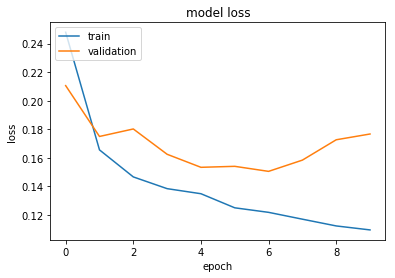

In [250]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()